In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.optimizers import SGD
from scipy.integrate import quad, nquad

2024-07-10 17:28:13.891947: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-10 17:28:13.972021: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-10 17:28:14.092000: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-10 17:28:14.203732: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-10 17:28:14.204418: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-10 17:28:14.379144: I tensorflow/core/platform/cpu_feature_guard.cc:

## Set hyperparameters

In [2]:
dim = 2
initilizer = RandomNormal(mean=0.0, stddev=25.0)

activation_func = "relu"

def create_model(input_dim):
    hidden_dim = 4 * input_dim
    output_dim = 1

    model = Sequential()
    model.add(Input(shape=(input_dim,)))
    #model.add(Dense(units=hidden_dim, activation=activation_func, kernel_initializer=initilizer))
    #model.add(Dense(units=hidden_dim, activation=activation_func, kernel_initializer=initilizer))
    #model.add(Dense(units=hidden_dim, activation=activation_func, kernel_initializer=initilizer))
    model.add(Dense(units=output_dim, kernel_initializer=initilizer))

    return model

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=10000, decay_rate=0.9
)

opt = keras.optimizers.Adam(learning_rate=lr_schedule)

2024-07-10 17:28:16.845158: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-10 17:28:16.846066: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [3]:
rho = 0.05
gamma = 1
tau = 1

def f(x):
    return x[:, 0] + x[:, 1]

# def h_i(x, i):
#     return x ** 2  # Tbc

# def g(x):
#     return x ** 2  # tbc

# def mu_i_density(x, i):
#     return np.exp(-x**2 / 2) / np.sqrt(2 * np.pi)  # tbc

# def sample_mu(n_samples, dim):
#     return tf.random.normal((n_samples, dim))  # tbc

def beta_gamma(x):
    return gamma * tf.maximum(0.0, x) ** 2

def cost_function(x, y):
    return tf.sqrt(tf.reduce_sum((x - y) ** 2))

# def theta(x, y):
#     return 1

## Create models

In [4]:
g_model = create_model(dim)
h_models = [create_model(1) for _ in range(dim)]
lambda_model = Sequential([Input(shape=(1,)),
                           Dense(units=1, activation="relu", kernel_initializer=tf.constant_initializer(1), bias_initializer=tf.constant_initializer(np.pi))])


class CombinedModel(tf.keras.Model):
    def __init__(self, g_model, h_models, lambda_model):
        super(CombinedModel, self).__init__()
        self.lambda_model = lambda_model
        self.h_models = h_models
        self.g_model = g_model

    def call(self, inputs):
        h_outputs = [h_model(inputs[:, i:i+1]) for i, h_model in enumerate(self.h_models)]
        g_output = self.g_model(inputs[:, dim:-1])
        lambda_output = self.lambda_model(inputs[:, -1:])
        return g_output, h_outputs, lambda_output


combined_model = CombinedModel(g_model, h_models, lambda_model)

## Loss function

In [5]:
def phi_theta_gamma(samples):
    h_integral = tf.reduce_sum([tf.reduce_mean(h_model(samples[:, i:i+1])) for i, h_model in enumerate(h_models)])
    g_integral = tf.reduce_mean(g_model(samples[:, dim:-1]))
    lamda_value = lambda_model(samples[:, -1:])
    
    y_samples = tf.random.uniform((tf.shape(samples)[0], dim), minval=0, maxval=1)

    theta_integral = tf.reduce_mean(beta_gamma(
        f(samples[:, dim:-1]) - g_model(y_samples)
        - tf.reduce_sum([h_model(samples[:, i:i+1]) for i, h_model in enumerate(h_models)])
        - lamda_value * cost_function(y_samples, samples[:, dim:-1])))

    return lamda_value * rho + h_integral + g_integral + theta_integral


class CustomLoss(tf.keras.losses.Loss):
    def __init__(self):
        super().__init__()
    
    def call(self, x_pred, x_true):
        return phi_theta_gamma(x_pred)
    
combined_model.compile(optimizer='adam', loss=CustomLoss())

# combined_model.summary()
# combined_model.g_model.summary()
# for model in combined_model.h_models:
#     model.summary()
# combined_model.lambda_model.summary()

In [6]:
n_samples = 10 ** 4
x_samples = tf.random.uniform((n_samples, 2 * dim), minval=0, maxval=1).numpy()

lambda_samples = np.zeros(n_samples)
lambda_samples = lambda_samples.reshape(-1, 1)

x_samples = np.hstack((x_samples, lambda_samples))
x_true_irrelevant = np.zeros_like(x_samples)

combined_model.fit(x=x_samples,y=x_true_irrelevant, epochs=5, batch_size=32)

print(combined_model.get_weights())
for model in combined_model.h_models:
    print(model.get_weights())
print(combined_model.g_model.get_weights())

Epoch 1/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 869us/step - loss: 0.2969
Epoch 2/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step - loss: -0.1188
Epoch 3/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -0.4249
Epoch 4/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step - loss: -0.7408
Epoch 5/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 845us/step - loss: -1.0566
[array([[1.]], dtype=float32), array([3.5316133], dtype=float32), array([[15.872666]], dtype=float32), array([0.05047512], dtype=float32), array([[15.872666]], dtype=float32), array([0.05047512], dtype=float32), array([[ 16.180147],
       [-20.49162 ]], dtype=float32), array([-1.5824938], dtype=float32)]
[array([[15.872666]], dtype=float32), array([0.05047512], dtype=float32)]
[array([[15.872666]], dtype=float32), array([0.05047512], dtype=float32)]
[array([[ 16.180147],
       [-20.49162 ]], dtype=float32), array([-1.5824938], dtype=float32)]


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


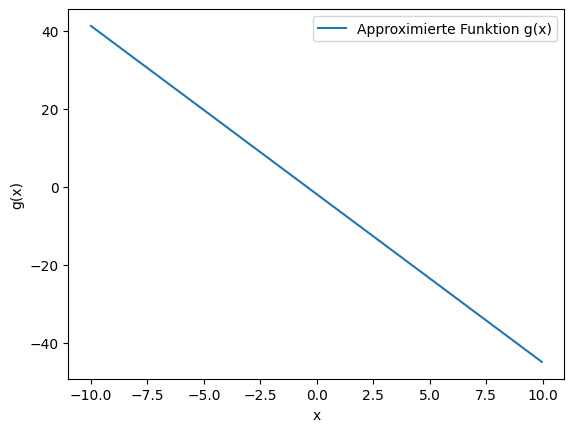

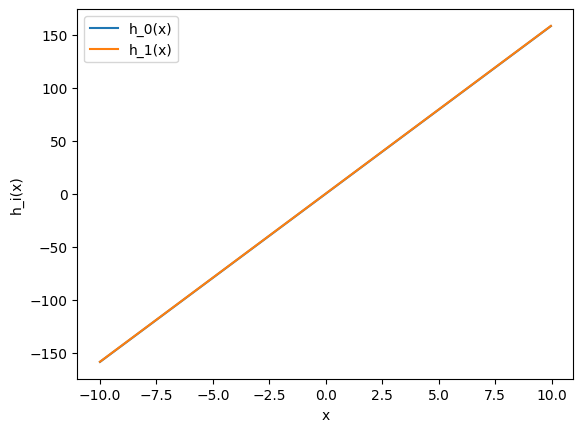

In [7]:
n_test = 500

x_test = tf.linspace(-10.0, 10.0, n_test * 2 * dim)
x_test = tf.reshape(x_test, (-1, 2 * dim))
lambda_test = np.zeros(n_test)
lambda_test = lambda_test.reshape(-1, 1)

x_test = np.hstack((x_test, lambda_test))

# Vorhersagen mit dem kombinierten Modell
g_predictions, h_predictions, lambda_predictions = combined_model.predict(x_test)

# Visualization of g_predictions
plt.plot(x_test[:, 0], g_predictions, label='Approximierte Funktion g(x)')
plt.xlabel('x')
plt.ylabel('g(x)')
plt.legend()
plt.show()

# Visualization of h_i predictions
for i in range(dim):
    plt.plot(x_test[:, 0], h_predictions[i], label=f'h_{i}(x)')

plt.xlabel('x')
plt.ylabel('h_i(x)')
plt.legend()
plt.show()